# Genetic algorithm

### Libraries

In [2]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

### Initializations and auxiliar methods

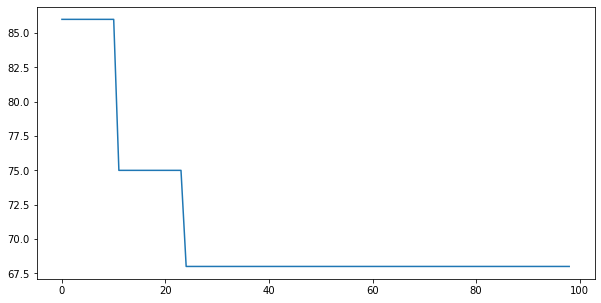

In [14]:
class GA:

    def __init__(self,time_deadline,problem_path,**kwargs): #the default values for these parameters should be the best values found in the experimental optimization of the algorithm.
        self.problem_path = problem_path
        self.best_solution = None 
        self.time_deadline = time_deadline 
        self.best_fitness = None

        self.evolution = []
        
        #TODO : Completar método para configurar el algoritmo genético (e.g., seleccionar cruce, mutación, etc.)

    def get_best_solution(self):  #Returns best solution found up to any point. Have to be a list of lists (each list contains the tour taken by each vehicle)
        
        return self.translate_solution(self.best_solution)

    def read_problem_instance(self): #Process the .txt file with the instance of the problem
        with open(self.problem_path, "r") as f:
            text = f.read()
        lines = text.strip().split('\n')
        num_locations = int(lines[0].split()[1])
        num_vehicles = int(lines[1].split()[1])

        matrix_lines = [line.split() for line in lines[3:]]
        distance_matrix = np.array(matrix_lines, dtype=float)

        return num_locations,num_vehicles,distance_matrix


    ''' ------------------- Auxiliar methods ------------------- '''

    def translate_solution(self,solution):
        final = []
        aux = [0]
        for s in solution:
            if s > 0:
                aux.append(s)
            else:
                aux.append(0)
                final.append(aux)
                aux=[0]
            
        aux.append(0)
        final.append(aux)
        return final

    def transform_solution(self,solution):
        final = []
        aux = []
        for s in solution:
            if s > 0:
                aux.append(s)
            else:
                final.append(aux) 
                aux=[] 
        final.append(aux)
        return final

    def inverted_transformation(self,solution):
        final = []
        for i,elem in enumerate(solution):
            for n in elem:
                final.append(n)
            if i !=len(solution)-1:
                final.append(0)
        return final
    
    def create_individual(self,n_locations,n_vehicles): 
        aux = [0]*(n_vehicles-1)
        rnge = list(range(1,n_locations))
        individual = aux+rnge
        random.shuffle(individual)
        return individual
    
    def create_population(self,n_locations,n_vehicles,n_individuals):
        population=[]
        for i in range(n_individuals):
            population.append(self.create_individual(n_locations,n_vehicles))
        return population
    
    def greedy_heuristic(self,dist_matrix, n_vehicles,n_locations):
        routes = [[] for _ in range(n_vehicles)]
        visited = set()
        visited.add(0)  # Assuming the depot is at index 0

        for route in routes:   # Initialize routes with the depot
            route.append(0)

        # Assign locations to vehicles
        while len(visited) < n_locations:
            for route in routes:
                if len(visited) == n_locations:
                    break
                last_location = route[-1]
                closest_distance = float('inf')
                closest_location = None
                for i in range(n_locations):
                    if i not in visited and dist_matrix[last_location][i] < closest_distance:
                        closest_distance = dist_matrix[last_location][i]
                        closest_location = i
                route.append(closest_location)
                visited.add(closest_location)

        for route in routes:
            route.append(0)
        routes = [r[:-1] for r in routes]
        population = list(itertools.chain.from_iterable(routes))
        population = population[1:]

        return population
    
    def fitness(self,solution,dist_matrix):
    
        """
        If the solution is in format : [1,3,6,0,10,5,9,0,7,4,8,2] (permutation representation) We should calculate the fitness of that solution
        as 1/total distance traveled by that vehicle
        """
        total_distance = 0
        origin = 0
        for n in solution:
            destination=n
            total_distance += dist_matrix[origin][destination]
            origin = n

        destination=0
        total_distance+=dist_matrix[origin][destination]
        return 1/total_distance
    
    def select_parent(self,population_fitness, n=4, m=100):
        if n<m and n%2 == 0:
            #Randomly sample m individuals from population
            sampled_individuals = random.sample(population_fitness, m)

            #Sort according to fitness (best individuals first)
            sorted_individuals = sorted(sampled_individuals, key=lambda x: x[0], reverse=True)

            #Select the top n individuals from the m individuals sampled
            selected_parents = sorted_individuals[:n]
            selected_parents = [parent[1] for parent in selected_parents]

            return selected_parents
        
        else:
            print("n is not less than m or n is not even")

    def inspired_crossover_DPX(self,parent1,parent2):
        n = len(parent1)
        c1 = [0] * n
        c2 = [0] * n

        #Copy ends of the parents to opposite positions in the children
        c1[0] = parent2[n - 1]
        c2[0] = parent1[n - 1]
        c1[n - 1] = parent2[0]
        c2[n - 1] = parent1[0]
        
        #Swap remaining cities as given algorithm from paper
        for i in range(n):
            for j in range(1, n - 1):
                if parent2[i] == parent1[j]:
                    c1[j] = parent2[j]
                if parent1[i] == parent2[j]:
                    c2[j] = parent1[j]

        return c1, c2
    
    def extract_chromosome(self,solution):
        final = self.transform_solution(solution)
        n = random.randint(0,len(final)-1)
        return final, n
    
    def inversion_mutaion(self,chromosome):
        index1, index2 = random.sample(range(len(chromosome)), 2)
        start_index = min(index1, index2)
        end_index = max(index1, index2)
        inverted = chromosome[:start_index] + list(reversed(chromosome[start_index:end_index + 1])) + chromosome[end_index + 1:]
        return inverted
    
    def in_route_mutation(self,chromosome):

        chromosome_length = len(chromosome)

        # Choose random indices for the subsection
        start_idx = random.randint(0, chromosome_length - 1)
        end_idx = random.randint(start_idx + 1, chromosome_length)
        
        # Select the subsection to be reversed
        subsection = chromosome[start_idx:end_idx]
        
        # Perform in-route mutation by reversing the subsection
        mutated_chromosome = chromosome[:start_idx] + subsection[::-1] + chromosome[end_idx:]
        
        return mutated_chromosome
    
    def cross_route_mutation(self,solution):
        """
        This function applies Cross-route mutation where we mutate the routes of different
        salesmen in order to generate the new population
        """

        #Ensure there are at least two salesmen for mutation
        final = self.transform_solution(solution)

        if len(final) < 2:
            return final
        
        #Choose two distinct random indices representing salesmen
        salesman_1_idx, salesman_2_idx = random.sample(range(len(final)), 2)
        
        #Select random subsections from the chosen salesmen
        salesman_1 = final[salesman_1_idx]
        salesman_2 = final[salesman_2_idx]
        
        #Ensure the subsections are not empty
        if len(salesman_1) == 0 or len(salesman_2) == 0:
            return self.inverted_transformation(final)
        
        #Choose random subsections within the salesmen
        start_idx_1 = random.randint(0, len(salesman_1) - 1)
        end_idx_1 = random.randint(start_idx_1 + 1, len(salesman_1))
        
        start_idx_2 = random.randint(0, len(salesman_2) - 1)
        end_idx_2 = random.randint(start_idx_2 + 1, len(salesman_2))
        
        #Swap the subsections between the two salesmen
        mutated_final = final.copy()
        mutated_final[salesman_1_idx] = salesman_1[:start_idx_1] + salesman_2[start_idx_2:end_idx_2] + salesman_1[end_idx_1:]
        mutated_final[salesman_2_idx] = salesman_2[:start_idx_2] + salesman_1[start_idx_1:end_idx_1] + salesman_2[end_idx_2:]
        
        return self.inverted_transformation(mutated_final)
    
    def replace_cmin(self, fitness, offspring):
        # CD/RW strategy for replacing cmin
        cmin = min(fitness, key=lambda x: self.contribution_of_diversity(x[1], [ind[1] for ind in fitness]))
        fitness_without_cmin = [ind for ind in fitness if ind != cmin]

        # Check if offspring provides more diversity than cmin
        if self.contribution_of_diversity(offspring, [ind[1] for ind in fitness_without_cmin]) > self.contribution_of_diversity(cmin[1], [ind[1] for ind in fitness]):
            fitness.remove(cmin)
        else:
            # Using replace by worst otherwise
            self.replace_by_worst(fitness, offspring)
        return [ind[1] for ind in fitness], fitness

    def replace_by_worst(self, fitness, offspring):
        # RW strategy for replacing the worst individual
        worst_individual = max(fitness, key=lambda x: x[0])
        offspring_fitness = next(fit[0] for fit in fitness if fit[1] == offspring)

        if offspring_fitness < worst_individual[0]:
            fitness.remove(worst_individual)

    def contribution_of_diversity(self, individual, population):
        # Calculate the contribution of diversity of an individual to a population based on the euclidean distance of the vectors
        distances = [np.linalg.norm(np.array(individual) - np.array(ind)) for ind in population]
        return float(np.sum(distances) / len(distances))
    
    def fitness_proportion_ranking_selection(self, fitness, k = 2):
        # Linear ranking selection
        # Sort individuals by fitness
        #print(fitness[1])
        #sorted_fitness = sorted(fitness, key=lambda x: x[0], reverse=True)
        #print(sorted_fitness[1])
        # Calculate selection probability for each individual
        cummulative = sum(x[0] for x in fitness)
        selection = []
        selection_fitness = []
        while len(selection) < k:
            i = random.randint(0, len(fitness)-1)
            f, ind = fitness[i]
            r = random.random()
            p = f/cummulative
            if r < p:
                selection.append(ind)
                selection_fitness.append((f, ind))
        #print(selection)
        # Select two individuals
        return selection, selection_fitness
    
    def linear_ranking_selection(self,fitness, s = 1.5, k = 2):
        f = sorted(fitness)
        selected = []
        for i, ft in enumerate(f):
            p = ((2-s)/len(f))+((2*i*(s-1))/(len(f)*(len(f)-1)))
            r = random.random()
            if r < p: 
                selected.append(ft)
            if len(selected) == k: break
        if len(selected)<k:
            selected = selected + list(f[-(k-len(selected)):])
        return selected
    
    def exponential_ranking_selection(self,fitness, c = 0.5, k = 2):
        f = sorted(fitness)
        selected = []
        for i, ft in enumerate(f):
            p = ((c-1)/(c*len(f) -1))(c**(len(f)-i-1))
            r = random.random()
            if r < p: 
                selected.append(ft)
            if len(selected) == k: break
        if len(selected)<k:
            selected = selected + list(f[-(k-len(selected)):])
        return selected
    
    def tournament_selection(self,fitness, k = 20, n= 2, p = 1):
        selected = []
        while len(selected) < n:
            sample = random.sample(fitness, k = k)
            r = random.random()
            if r < p:
                for j in range(1, len(sample)):
                    best = sorted(sample)[-j]
                    if best not in selected:
                        selected.append(best)
                        break
        return selected
    
    def run(self,individuals=300, crossovers= 1, max_iter=100, objective_value=0.2, proba_selection = [0.5,0.5]):
        '''Initialize population'''
        n_location,n_vehicles,instance = self.read_problem_instance()          
        population = self.create_population(n_location,n_vehicles,individuals) 
        
        #each of the starting populations was seeded with a solution produced by a simple greedy heuristic 
        #in order to give the GA a good starting point (paper)
        #population = self.greedy_heuristic(instance,n_vehicles,n_locations)
        '''Evaluate each solution and creating list with the fitness'''
        fitness = []
        self.evolution = []
        
        for s in population:                                                                                                                                                          
            f = self.fitness(s,instance)
            fitness.append((f, s))
            if self.best_fitness == None or f > self.best_fitness:          
                self.best_fitness = f
                self.best_solution = s
                
        n_iter = 0
        while (self.best_fitness is not None and self.best_fitness < objective_value and n_iter < max_iter) or  self.best_fitness is None: #Termination condition
            print("Iteration: ", n_iter, end = "\r")
            self.evolution.append(self.best_fitness)

                    
            for i in range(crossovers):  #Iterations specified in the configuration (10 by default)
                
                '''SELECT parent'''
                if random.random() < proba_selection[0]:
                    parents, _ = self.fitness_proportion_ranking_selection(fitness, k = 2)
                    parent1 =  parents[0]        
                    parent2 =  parents[1] 
                else:
                    parents = self.select_parent(fitness, n = 2)
                    parent1 =  parents[0]        
                    parent2 =  parents[1]   

                                                   

                '''CROSSOVER'''                                                                                            
                child1, child2 = self.inspired_crossover_DPX(parent1, parent2)                  
                
                '''MUTATION''' 
                #if random.random() < proba_mutation[0]:  
                _child1, n1 = self.extract_chromosome(child1)
                _child2, n2 = self.extract_chromosome(child2)
               
                _child1[n1] = self.in_route_mutation(_child1[n1])
                _child2[n2] = self.in_route_mutation(_child2[n2])

                child1 = self.inverted_transformation(_child1)
                child2 = self.inverted_transformation(_child2)

                #if random.random() < proba_mutation[1]:
                child1 = self.cross_route_mutation(child1)
                child2 = self.cross_route_mutation(child2)

                '''EVALUATION'''
                #print(child1)
                f1 = self.fitness(child1, instance)
                f2 = self.fitness(child2, instance)

                fitness.append((f1, child1))
                fitness.append((f2, child2))

                if self.best_fitness == None or f1 > self.best_fitness:
                    self.best_fitness = f1
                    self.best_solution = child1

                if self.best_fitness == None or f2 > self.best_fitness:
                    self.best_fitness = f2
                    self.best_solution = child2
            
                #selected_offspring = random.choice([child1, child2])      #This will continue with the diversity of the population but other methods can be implemented such as: selecting child with best fitness or by alternancy in each iteration.
                #population, fitness = self.replace_cmin(fitness, selected_offspring)
                
                
                population, fitness = self.replace_cmin(fitness, child1)
                population, fitness = self.replace_cmin(fitness, child2)
            
            if random.random() < proba_selection[1]:
                population2 = self.create_population(n_location,n_vehicles,individuals)
                for s in population2:                                                                                                                                                          
                    f = self.fitness(s,instance)
                    fitness.append((f, s))
                    population.append(s)
                    if self.best_fitness == None or f > self.best_fitness:          
                        self.best_fitness = f
                        self.best_solution = s
            
                population, fitness = self.fitness_proportion_ranking_selection(fitness, k = individuals)

                    
            n_iter += 1

        return self.translate_solution(self.best_solution)

    def plot_evolution(self):
        
        x = list(range(0,len(self.evolution[1:])))
        y = [1/x for x in self.evolution[1:]]

        # plot lines
        fig = plt.figure(figsize=(10,5))
        #ax = fig.add_subplot(111)
        #ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
        #ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

        plt.plot(x, y)
        plt.show()

if __name__ == '__main__':
    a = GA(0,'instances/instance1.txt')
    a.run(max_iter=100)
    a.plot_evolution()


## · INITIALIZE random population of solutions

### Create individual

In [ ]:
def create_individual(self,n_locations,n_vehicles): 
    aux = [0]*(n_vehicles-1)
    rnge = list(range(1,n_locations))
    individual = aux+rnge
    random.shuffle(individual)
    return individual

GA.create_individual = create_individual

### Create population

In [ ]:
def create_population(self,n_locations,n_vehicles,n_individuals):
    population=[]
    for i in range(n_individuals):
        population.append(self.create_individual(n_locations,n_vehicles))
    return population

GA.create_population = create_population

### Greedy Heuristic (to give GA a good starting point)

In [ ]:
def greedy_heuristic(self,dist_matrix, n_vehicles,n_locations):
    routes = [[] for _ in range(n_vehicles)]
    visited = set()
    visited.add(0)  # Assuming the depot is at index 0

    for route in routes:   # Initialize routes with the depot
        route.append(0)

    # Assign locations to vehicles
    while len(visited) < n_locations:
        for route in routes:
            if len(visited) == n_locations:
                break
            last_location = route[-1]
            closest_distance = float('inf')
            closest_location = None
            for i in range(n_locations):
                if i not in visited and dist_matrix[last_location][i] < closest_distance:
                    closest_distance = dist_matrix[last_location][i]
                    closest_location = i
            route.append(closest_location)
            visited.add(closest_location)

    for route in routes:
        route.append(0)
    routes = [r[:-1] for r in routes]
    population = list(itertools.chain.from_iterable(routes))
    population = population[1:]

    return population

GA.greedy_heuristic = greedy_heuristic

------------------------------------

## · EVALUATION of each solution

### Method **fitness()**
Function that measures the fitness of an individual in the environment -> Objective function

In [ ]:
def fitness(self,solution,dist_matrix):
    
    """
    If the solution is in format : [1,3,6,0,10,5,9,0,7,4,8,2] (permutation representation) We should calculate the fitness of that solution
    as 1/total distance traveled by that vehicle
    """
    total_distance = 0
    origin = 0
    for n in solution:
        destination=n
        total_distance += dist_matrix[origin][destination]
        origin = n

    destination=0
    total_distance+=dist_matrix[origin][destination]
    return 1/total_distance

GA.fitness = fitness

--------------------

## · SELECT parent

### Method **select_parent()**

In [ ]:
def select_parent(self,population_fitness, n=4, m=100):
    if n<m and n%2 == 0:
        #Randomly sample m individuals from population
        sampled_individuals = random.sample(population_fitness, m)

        #Sort according to fitness (best individuals first)
        sorted_individuals = sorted(sampled_individuals, key=lambda x: x[0], reverse=True)

        #Select the top n individuals from the m individuals sampled
        selected_parents = sorted_individuals[:n]
        selected_parents = [parent[1] for parent in selected_parents]

        return selected_parents
    
    else:
        print("n is not less than m or n is not even")

GA.select_parent = select_parent

------------------

## · CROSSOVER

### Method **inspired_crossover_DPX()**

In [ ]:
def inspired_crossover_DPX(self,parent1,parent2):
    n = len(parent1)
    c1 = [0] * n
    c2 = [0] * n

    #Copy ends of the parents to opposite positions in the children
    c1[0] = parent2[n - 1]
    c2[0] = parent1[n - 1]
    c1[n - 1] = parent2[0]
    c2[n - 1] = parent1[0]
    
    #Swap remaining cities as given algorithm from paper
    for i in range(n):
        for j in range(1, n - 1):
            if parent2[i] == parent1[j]:
                c1[j] = parent2[j]
            if parent1[i] == parent2[j]:
                c2[j] = parent1[j]

    return c1, c2

GA.inspired_crossover_DPX = inspired_crossover_DPX

-------------------

## · MUTATION

### Method **extract_chromosome()**

In [ ]:
def extract_chromosome(self,solution):
        final = self.transform_solution(solution)
        n = random.randint(0,len(final)-1)
        return final, n

GA.extract_chromosome = extract_chromosome

### Method **in_route_mutation()**

In [ ]:
def in_route_mutation(self,chromosome):

    chromosome_length = len(chromosome)

    # Choose random indices for the subsection
    start_idx = random.randint(0, chromosome_length - 1)
    end_idx = random.randint(start_idx + 1, chromosome_length)
    
    # Select the subsection to be reversed
    subsection = chromosome[start_idx:end_idx]
    
    # Perform in-route mutation by reversing the subsection
    mutated_chromosome = chromosome[:start_idx] + subsection[::-1] + chromosome[end_idx:]
    
    return mutated_chromosome

GA.in_route_mutation = in_route_mutation

### Method **cross_route_mutation()**

In [ ]:
def cross_route_mutation(self,solution):
    """
    This function applies Cross-route mutation where we mutate the routes of different
    salesmen in order to generate the new population
    """

    #Ensure there are at least two salesmen for mutation
    final = self.transform_solution(solution)

    if len(final) < 2:
        return final
    
    #Choose two distinct random indices representing salesmen
    salesman_1_idx, salesman_2_idx = random.sample(range(len(final)), 2)
    
    #Select random subsections from the chosen salesmen
    salesman_1 = final[salesman_1_idx]
    salesman_2 = final[salesman_2_idx]
    
    #Ensure the subsections are not empty
    if len(salesman_1) == 0 or len(salesman_2) == 0:
        return final
    
    #Choose random subsections within the salesmen
    start_idx_1 = random.randint(0, len(salesman_1) - 1)
    end_idx_1 = random.randint(start_idx_1 + 1, len(salesman_1))
    
    start_idx_2 = random.randint(0, len(salesman_2) - 1)
    end_idx_2 = random.randint(start_idx_2 + 1, len(salesman_2))
    
    #Swap the subsections between the two salesmen
    mutated_final = final.copy()
    mutated_final[salesman_1_idx] = salesman_1[:start_idx_1] + salesman_2[start_idx_2:end_idx_2] + salesman_1[end_idx_1:]
    mutated_final[salesman_2_idx] = salesman_2[:start_idx_2] + salesman_1[start_idx_1:end_idx_1] + salesman_2[end_idx_2:]
    
    return self.inverted_transformation(mutated_final)

GA.cross_route_mutation = cross_route_mutation

---------------

## · REPLACE POPULATION

Replacement strategy based on the contribution of diversity of the new offspring to the population where it will be included. The idea is to replace an individual of the population, with a poorer fitness function value and with a lower contribution to diversity, by the offspring.

In [ ]:

def replace_cmin(self, fitness, offspring):
    # CD/RW strategy for replacing cmin
    cmin = min(fitness, key=lambda x: self.contribution_of_diversity(x[1], [ind[1] for ind in fitness]))
    fitness_without_cmin = [ind for ind in fitness if ind != cmin]

    # Check if offspring provides more diversity than cmin
    if self.contribution_of_diversity(offspring, [ind[1] for ind in fitness_without_cmin]) > self.contribution_of_diversity(cmin[1], [ind[1] for ind in fitness]):
        fitness.remove(cmin)
    else:
        # Using replace by worst otherwise
        self.replace_by_worst(fitness, offspring)
    return [ind[1] for ind in fitness], fitness

def replace_by_worst(self, fitness, offspring):
    # RW strategy for replacing the worst individual
    worst_individual = max(fitness, key=lambda x: x[0])
    offspring_fitness = next(fit[0] for fit in fitness if fit[1] == offspring)

    if offspring_fitness < worst_individual[0]:
        fitness.remove(worst_individual)

def contribution_of_diversity(self, individual, population):
    # Calculate the contribution of diversity of an individual to a population based on the euclidean distance of the vectors
    distances = [np.linalg.norm(np.array(individual) - np.array(ind)) for ind in population]
    return float(np.sum(distances) / len(distances))


def linear_ranking_selection(self, fitness, k = 2):
    # Linear ranking selection
    # Sort individuals by fitness
    sorted_fitness = sorted(fitness, key=lambda x: x[0], reverse=True)
    # Calculate selection probability for each individual
    cummulative = sum(x[0] for x in fitness)
    selection_probability = [(x[0] / cummulative) for x in fitness]
    # Select two individuals
    selected_individuals = random.choices(sorted_fitness, weights=selection_probability, k=k)
    return selected_individuals, [ind[1] for ind in selected_individuals]

GA.replace_cmin = replace_cmin
GA.replace_by_worst = replace_by_worst
GA.contribution_of_diversity = contribution_of_diversity
GA.linear_ranking_selection = linear_ranking_selection
        

------------------

### - Method   **run()**

In [ ]:
def run(self,individuals=300, crossovers= 1, max_iter=100, objective_value=0.1, proba_crossover = [0.5], proba_mutation = [0.5,0.5], proba_selection = [0.5,0.5]):
        '''Initialize population'''
        n_location,n_vehicles,instance = self.read_problem_instance()          
        population = self.create_population(n_location,n_vehicles,individuals) 
        
        #each of the starting populations was seeded with a solution produced by a simple greedy heuristic 
        #in order to give the GA a good starting point (paper)
        #population = self.greedy_heuristic(instance,n_vehicles,n_locations)
        '''Evaluate each solution and creating list with the fitness'''
        fitness = []
        self.evolution = []
        
        for s in population:                                                                                                                                                          
            f = self.fitness(s,instance)
            fitness.append((f, s))
            if self.best_fitness == None or f > self.best_fitness:          
                self.best_fitness = f
                self.best_solution = s
                
        n_iter = 0
        while (self.best_fitness is not None and self.best_fitness < objective_value and n_iter < max_iter) or  self.best_fitness is None: #Termination condition
            print("Iteration: ", n_iter, end = "\r")
            self.evolution.append(self.best_fitness)

                    
            for i in range(crossovers):  #Iterations specified in the configuration (10 by default)
                
                '''SELECT parent'''
                if random.random() < proba_selection[1]:
                    parents = self.select_parent(fitness, n = 2)
                    parent1 =  parents[0]        
                    parent2 =  parents[1]  
                else:
                    _, parents = self.linear_ranking_selection(fitness, k = 2)
                    parent1 =  parents[0]        
                    parent2 =  parents[1]                                          

                '''CROSSOVER''' 
                if random.random() < proba_crossover[0]:                                                                                             
                    child1, child2 = self.inspired_crossover_DPX(parent1, parent2)                                                         
                else: child1, child2 = parent1.copy(), parent2.copy()
                
                '''MUTATION''' 
                if random.random() < proba_mutation[0]:  
                    _child1, n1 = self.extract_chromosome(child1)
                    _child2, n2 = self.extract_chromosome(child2)

                    _child1[n1] = self.in_route_mutation(_child1[n1])
                    _child2[n2] = self.in_route_mutation(_child2[n2])

                    child1 = self.inverted_transformation(_child1)
                    child2 = self.inverted_transformation(_child2)

                if random.random() < proba_mutation[1]:
                    child1 = self.cross_route_mutation(child1)
                    child2 = self.cross_route_mutation(child2)

                '''EVALUATION'''
                f1 = self.fitness(child1, instance)
                f2 = self.fitness(child2, instance)

                fitness.append((f1, child1))
                fitness.append((f2, child2))

                if self.best_fitness == None or f1 > self.best_fitness:
                    self.best_fitness = f1
                    self.best_solution = child1

                if self.best_fitness == None or f2 > self.best_fitness:
                    self.best_fitness = f2
                    self.best_solution = child2
            
                #selected_offspring = random.choice([child1, child2])      #This will continue with the diversity of the population but other methods can be implemented such as: selecting child with best fitness or by alternancy in each iteration.
                #population, fitness = self.replace_cmin(fitness, selected_offspring)
                
                if random.random() < proba_selection[0]:
                    population, fitness = self.replace_cmin(fitness, child1)
                    population, fitness = self.replace_cmin(fitness, child2)
                
                if random.random() < proba_selection[1] & len(fitness) < individuals:
                    fitness, population = self.linear_ranking_selection(fitness, k = 2)
                    
            n_iter += 1

        return self.translate_solution(self.best_solution)

def plot_evolution(self):
    import matplotlib.pyplot as plt
    x = list(range(0,len(self.evolution[1:])))
    y = [1/x for x in self.evolution[1:]]

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

    plt.plot(x, y)
    plt.show()
GA.run = run
GA.plot_evolution = plot_evolution

In [ ]:
a = GA(0,'instance1.txt')
a.run(max_iter=100)


[[0, 13, 11, 0], [0, 16, 6, 15, 8, 0], [0, 12, 7, 14, 4, 3, 5, 10, 2, 9, 1, 0]]

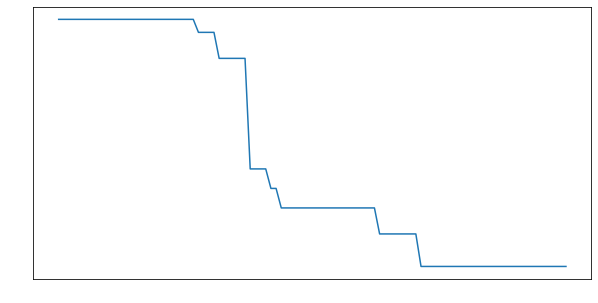

In [112]:
a.plot_evolution()

In [68]:
a.best_solution, 1/a.best_fitness

([1, 13, 10, 11, 16, 0, 12, 5, 3, 4, 14, 15, 6, 8, 9, 0, 7, 2], 97.0)

In [69]:
n_locations,n_vehicles,instance = a.read_problem_instance()
1/a.fitness(a.create_individual(n_locations,n_vehicles),instance)

10337.0